# Regression Pipeline

## Normale Regression

In [67]:
import pandas as pd
from pathlib import Path

DATA_ROOT = Path("/Users/jakobschneider/Machine Learning/Data_LCC")
PATH = DATA_ROOT / "model_table_imo_2024.parquet"

df = pd.read_parquet(PATH)

# --- Quality filter ---
df_valid = df[df["quality_ok"] == True].copy()

# --- Remove invalid target artefacts ---
TARGET = "y_co2_per_nm_kg"

y = df_valid[TARGET].astype(str)

# explizit nur den bekannten MRV-Artefakt entfernen
df_valid = df_valid[y != "Division by zero!"].copy()

# danach harte numerische Konvertierung
df_valid[TARGET] = pd.to_numeric(
    df_valid[TARGET],
    errors="raise"
)

### Feature Definition

In [68]:
NUM_FEATURES = [
    "sog_p50_kn",
    "sog_p95_kn",
    "moving_share",
    "Length",
    "Width",
    "draft_m_median",
]

CAT_FEATURES = ["VesselType"]

REQUIRED_COLS = [TARGET] + NUM_FEATURES + CAT_FEATURES

### NaNs entfernen

In [69]:
df_valid = df_valid.dropna(subset=REQUIRED_COLS).copy()

### Ausreißer entfernen (Zielvariable)

In [70]:
# Inspect how many ships are affected
(df_valid["y_co2_per_nm_kg"] > 2000).value_counts()

# Hard plausibility cap
df_valid = df_valid[
    df_valid["y_co2_per_nm_kg"] <= 2000
].copy()

print("Remaining rows:", df_valid.shape[0])
print(df_valid["y_co2_per_nm_kg"].describe())

Remaining rows: 4337
count    4337.000000
mean      356.445628
std       195.967709
min        94.380000
25%       236.090000
50%       290.050000
75%       408.330000
max      1830.060000
Name: y_co2_per_nm_kg, dtype: float64


### Sanity Checks

In [71]:
df_valid = df_valid[
    (df_valid[TARGET] > 0) &
    (df_valid["moving_share"].between(0, 1)) &
    (df_valid["sog_p50_kn"] >= 0) &
    (df_valid["sog_p95_kn"] >= 0)
].copy()

print("Final regression rows:", df_valid.shape[0])
print("Target range:", df_valid[TARGET].min(), df_valid[TARGET].max())

Final regression rows: 4337
Target range: 94.38 1830.06


### Feature matrix + Target

In [72]:
X = df_valid[NUM_FEATURES + CAT_FEATURES]
y = df_valid[TARGET]

### Preprocessing der Features

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_preprocess = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_preprocess = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, NUM_FEATURES),
        ("cat", categorical_preprocess, CAT_FEATURES),
    ],
    remainder="drop"
)

### Modell

In [74]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()

### Pipeline zusammenfügen

In [75]:
regression_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", regressor),
    ]
)

### Train Test Split nach IMO

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

### Fit & Evaluation 

In [77]:
from sklearn.metrics import mean_absolute_error, r2_score

regression_pipeline.fit(X_train, y_train)

y_pred_train = regression_pipeline.predict(X_train)
y_pred_test  = regression_pipeline.predict(X_test)

print("TRAIN")
print("MAE:", mean_absolute_error(y_train, y_pred_train))
print("R² :", r2_score(y_train, y_pred_train))

print("\nTEST")
print("MAE:", mean_absolute_error(y_test, y_pred_test))
print("R² :", r2_score(y_test, y_pred_test))

TRAIN
MAE: 56.96483668898799
R² : 0.8178065075298934

TEST
MAE: 57.66896075773545
R² : 0.8237741661459574


## Log Transformation
- Zielvariable ist rechtsschief
- mit Log Transformation wird ein besseres Ergebnis erwartet

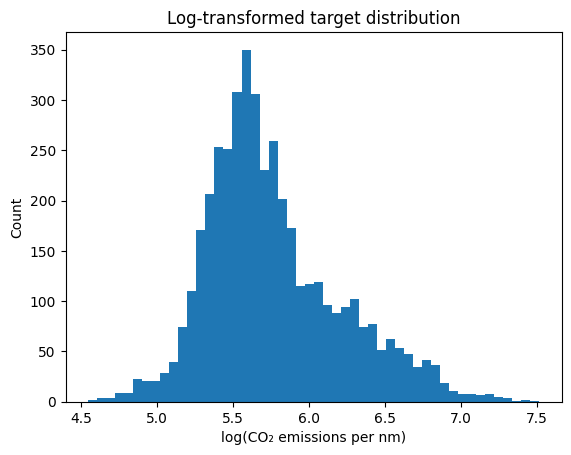

In [79]:
import numpy as np
import matplotlib.pyplot as plt

log_y = np.log(df_valid["y_co2_per_nm_kg"])

plt.figure()
plt.hist(log_y, bins=50)
plt.xlabel("log(CO₂ emissions per nm)")
plt.ylabel("Count")
plt.title("Log-transformed target distribution")
plt.show()

### Log Target erzeugen

In [80]:
df_model = df_valid.copy()

df_model["log_y"] = np.log(df_model[TARGET])

In [81]:
X = df_model[NUM_FEATURES + CAT_FEATURES]
y_log = df_model["log_y"]

### Train Test Split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log,
    test_size=0.2,
    random_state=42
)

### Preprocessing

In [83]:
numeric_preprocess = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_preprocess = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, NUM_FEATURES),
        ("cat", categorical_preprocess, CAT_FEATURES),
    ],
    remainder="drop"
)

### Regression Pipeline

In [84]:
regressor = LinearRegression()

In [85]:
log_regression_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", regressor),
    ]
)

In [86]:
log_regression_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('regressor', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers 

### Evaluation

In [87]:
y_pred_train_log = log_regression_pipeline.predict(X_train)
y_pred_test_log  = log_regression_pipeline.predict(X_test)

print("LOG-SCALE PERFORMANCE")

print("\nTRAIN")
print("MAE (log):", mean_absolute_error(y_train, y_pred_train_log))
print("R²  (log):", r2_score(y_train, y_pred_train_log))

print("\nTEST")
print("MAE (log):", mean_absolute_error(y_test, y_pred_test_log))
print("R²  (log):", r2_score(y_test, y_pred_test_log))

LOG-SCALE PERFORMANCE

TRAIN
MAE (log): 0.13874333461588478
R²  (log): 0.8339844114593806

TEST
MAE (log): 0.14206490049415352
R²  (log): 0.8259642921072321


### Rücktransformation

In [88]:
df_model["y_pred_log"] = log_regression_pipeline.predict(X)
df_model["y_pred_kg"]  = np.exp(df_model["y_pred_log"])

df_model["residual_kg"] = df_model[TARGET] - df_model["y_pred_kg"]

### Fehlermaß auf Originalskala

In [89]:
mae_kg = mean_absolute_error(
    df_model[TARGET],
    df_model["y_pred_kg"]
)

print("MAE in kg CO2 / nm:", round(mae_kg, 2))

MAE in kg CO2 / nm: 51.2


In [90]:
threshold = df_model["residual_kg"].abs().quantile(0.95)

df_model["flag_anomaly"] = df_model["residual_kg"].abs() > threshold

print("Residual threshold (kg/nm):", round(threshold, 2))
print("Flagged ships:", int(df_model["flag_anomaly"].sum()))

Residual threshold (kg/nm): 169.75
Flagged ships: 217


### Model speichern

In [91]:
import joblib
from pathlib import Path

MODEL_DIR = Path("/Users/jakobschneider/Machine Learning/Data_LCC/models")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = MODEL_DIR / "log_regression_mrv_validation.joblib"

joblib.dump(log_regression_pipeline, MODEL_PATH)

print("Model saved to:", MODEL_PATH)

# Save feature configuration for transparency
meta = {
    "target": "log(y_co2_per_nm_kg)",
    "num_features": NUM_FEATURES,
    "cat_features": CAT_FEATURES,
    "plausibility_cap": 2000,
}

joblib.dump(meta, MODEL_DIR / "model_metadata.joblib")

Model saved to: /Users/jakobschneider/Machine Learning/Data_LCC/models/log_regression_mrv_validation.joblib


['/Users/jakobschneider/Machine Learning/Data_LCC/models/model_metadata.joblib']

## Sensivitätsanalyse

### Robustness Check
Dimensionen:
* Outlier Cap
* Feature Set
* Modelltyp

In [92]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge

def run_model(df, num_features, cat_features, model):
    X = df[num_features + cat_features]
    y = np.log(df["y_co2_per_nm_kg"])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    numeric_preprocess = Pipeline(
        steps=[("scaler", StandardScaler())]
    )

    categorical_preprocess = Pipeline(
        steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_preprocess, num_features),
            ("cat", categorical_preprocess, cat_features),
        ]
    )

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("regressor", model),
        ]
    )

    pipe.fit(X_train, y_train)

    y_pred_test = pipe.predict(X_test)

    return {
        "mae_log": mean_absolute_error(y_test, y_pred_test),
        "r2_log": r2_score(y_test, y_pred_test),
    }

### 1. Outlier Cap

In [93]:
caps = [1500, 2000, 2500]
results = []

for cap in caps:
    df_cap = df_valid[df_valid["y_co2_per_nm_kg"] <= cap].copy()

    metrics = run_model(
        df_cap,
        NUM_FEATURES,
        CAT_FEATURES,
        LinearRegression()
    )

    results.append({
        "scenario": f"cap_{cap}",
        **metrics
    })

### 2. Feature Ablation

In [95]:
feature_sets = {
    "full": NUM_FEATURES,
    "no_p50": [f for f in NUM_FEATURES if f != "sog_p50_kn"],
    "no_draft": [f for f in NUM_FEATURES if f != "draft_m_median"],
}

for name, feats in feature_sets.items():
    metrics = run_model(
        df_valid,
        feats,
        CAT_FEATURES,
        LinearRegression()
    )

    results.append({
        "scenario": f"features_{name}",
        **metrics
    })

### 3. Modelltyp

In [97]:
models = {
    "linear": LinearRegression(),
    "ridge_1.0": Ridge(alpha=1.0),
    "ridge_10": Ridge(alpha=10.0),
}

for name, model in models.items():
    metrics = run_model(
        df_valid,
        NUM_FEATURES,
        CAT_FEATURES,
        model
    )

    results.append({
        "scenario": f"model_{name}",
        **metrics
    })

In [98]:
df_sensitivity = pd.DataFrame(results)
df_sensitivity = df_sensitivity.sort_values("r2_log", ascending=False)

df_sensitivity

,scenario,mae_log,r2_log
1,cap_2000,0.142065,0.825964
2,cap_2500,0.142065,0.825964
3,features_full,0.142065,0.825964
6,model_linear,0.142065,0.825964
4,features_no_p50,0.142235,0.825799
7,model_ridge_1.0,0.142219,0.825704
5,features_no_draft,0.142696,0.824555
8,model_ridge_10,0.143079,0.823445
0,cap_1500,0.144442,0.798258


Interpretation:
* Cap ist sinnvoll gewählt, da niedriger das Ergebnis verschlechtert
* Das Modell wird primär von Speed + moving_share + Size getragen
* Kein Overfitting

## Koeffizienten analysieren (Log Modell)
* Was passiert wenn man einen Feature Block entfernt (size, type, speed, ...)

In [101]:
# Finales Feature-Set (wie im Log-Modell)
NUM_FEATURES = [
    "sog_p50_kn",
    "sog_p95_kn",
    "moving_share",
    "Length",
    "Width",
    "draft_m_median",
]

CAT_FEATURES = ["VesselType"]

# Blockweise Gruppierung
FEATURE_BLOCKS = {
    "all_features": NUM_FEATURES + CAT_FEATURES,

    "no_speed": [
        f for f in NUM_FEATURES + CAT_FEATURES
        if f not in ["sog_p50_kn", "sog_p95_kn"]
    ],

    "no_operations": [
        f for f in NUM_FEATURES + CAT_FEATURES
        if f != "moving_share"
    ],

    "no_size": [
        f for f in NUM_FEATURES + CAT_FEATURES
        if f not in ["Length", "Width", "draft_m_median"]
    ],

    "no_type": [
        f for f in NUM_FEATURES
    ],
}

In [102]:
def run_block_model(df, features):
    num_feats = [f for f in features if f in NUM_FEATURES]
    cat_feats = [f for f in features if f in CAT_FEATURES]

    X = df[features]
    y = np.log(df["y_co2_per_nm_kg"])

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    transformers = []
    if num_feats:
        transformers.append(
            ("num", StandardScaler(), num_feats)
        )
    if cat_feats:
        transformers.append(
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
        )

    preprocessor = ColumnTransformer(transformers)

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("regressor", LinearRegression()),
        ]
    )

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    return {
        "r2_log": r2_score(y_test, y_pred),
        "mae_log": mean_absolute_error(y_test, y_pred),
    }

In [104]:
results = []

for block_name, feats in FEATURE_BLOCKS.items():
    metrics = run_block_model(df_valid, feats)

    results.append({
        "block_removed": block_name,
        "r2_log": metrics["r2_log"],
        "mae_log": metrics["mae_log"],
    })

df_block_importance = (
    pd.DataFrame(results)
    .sort_values("r2_log", ascending=False)
)

df_block_importance

,block_removed,r2_log,mae_log
0,all_features,0.825964,0.142065
2,no_operations,0.825359,0.142708
1,no_speed,0.814671,0.146293
4,no_type,0.782758,0.156075
3,no_size,0.430408,0.265277


Interpretation
Hierarchie: 
1. Size
2. Speed
3. Type
4. Operation

Emissionsintensität ∝
* Grundwiderstand/Größe
* Leistungsanforderung
* Nutzungsmodus

Eine blockweise Ablationsanalyse zeigt, dass die Größe der Schiffe der dominierende Erklärungsfaktor für die Emissionsintensität ist. Durch die Entfernung größenbezogener Merkmale wird die Aussagekraft des Modells um fast die Hälfte reduziert. Geschwindigkeitsprofile leisten einen wichtigen sekundären Beitrag, während der Schiffstyp hauptsächlich systematische Unterschiede zwischen den Schiffsklassen erfasst. Betriebsmuster, wie beispielsweise der Anteil der Bewegung, tragen nur marginal zur Aussagekraft bei.

## Residuenanalyse 
* Residuum = yMRV - yRegression

In [105]:
df_res = df_model.copy()

df_res["residual_kg"] = (
    df_res["y_co2_per_nm_kg"] - df_res["y_pred_kg"]
)

df_res["residual_pct"] = (
    df_res["residual_kg"] / df_res["y_co2_per_nm_kg"]
)

### Verteilung der Residuen

In [106]:
df_res["residual_kg"].describe()

count    4337.000000
mean        5.068078
std        78.209803
min      -580.659881
25%       -33.154526
50%        -2.126380
75%        33.573361
max       671.029179
Name: residual_kg, dtype: float64

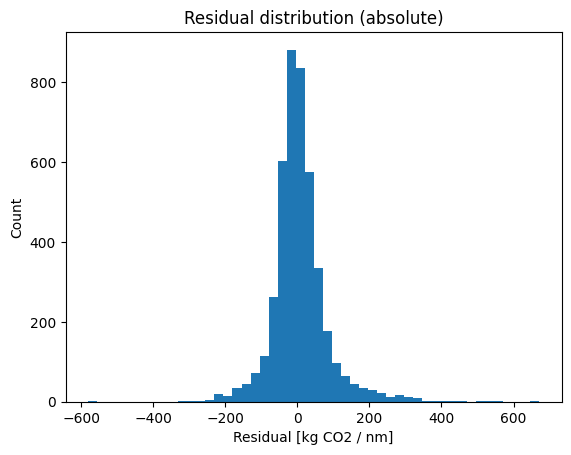

In [107]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_res["residual_kg"], bins=50)
plt.xlabel("Residual [kg CO2 / nm]")
plt.ylabel("Count")
plt.title("Residual distribution (absolute)")
plt.show()

Interpretation: gut kalibriert

### Relative Residuen
* Wichtig für Fairness zwischen großen und kleinen Schiffen

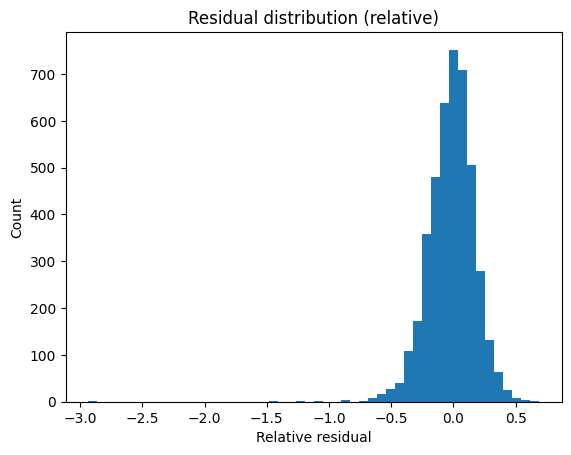

In [108]:
plt.figure()
plt.hist(df_res["residual_pct"], bins=50)
plt.xlabel("Relative residual")
plt.ylabel("Count")
plt.title("Residual distribution (relative)")
plt.show()

### Prüfen, ob Residuen strukturiert sind

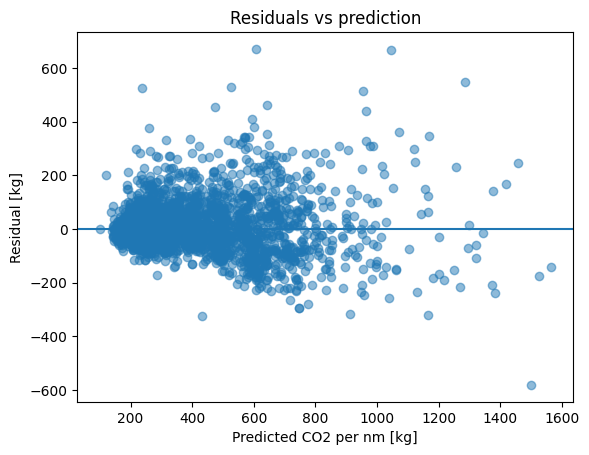

In [109]:
# Residuen vs. Vorhersage
plt.figure()
plt.scatter(df_res["y_pred_kg"], df_res["residual_kg"], alpha=0.5)
plt.axhline(0)
plt.xlabel("Predicted CO2 per nm [kg]")
plt.ylabel("Residual [kg]")
plt.title("Residuals vs prediction")
plt.show()

Interpretation: keine systematische Verzerrung

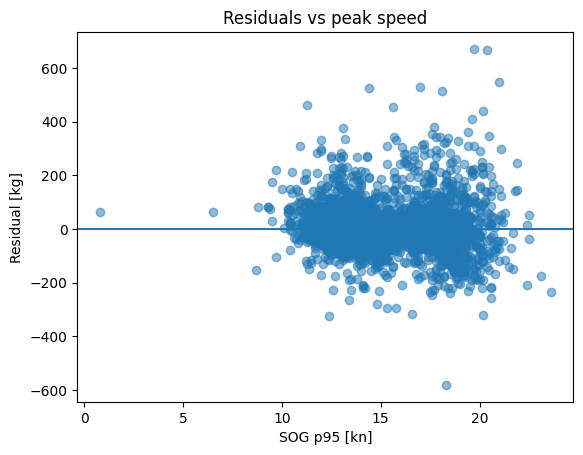

In [110]:
# Residuen vs. Geschwindigkeit
plt.figure()
plt.scatter(df_res["sog_p95_kn"], df_res["residual_kg"], alpha=0.5)
plt.axhline(0)
plt.xlabel("SOG p95 [kn]")
plt.ylabel("Residual [kg]")
plt.title("Residuals vs peak speed")
plt.show()

Interpretation: Speedeffekt ist weitgehend erfasst. Hohe Geschwindigkeit führt zu mehr Unsicherheit

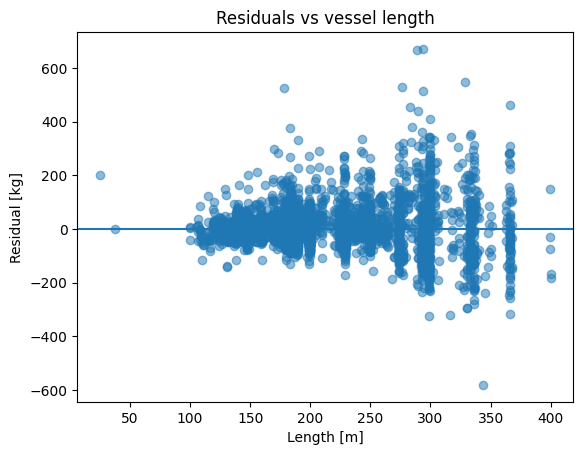

In [111]:
# Residuen nach Größe
plt.figure()
plt.scatter(df_res["Length"], df_res["residual_kg"], alpha=0.5)
plt.axhline(0)
plt.xlabel("Length [m]")
plt.ylabel("Residual [kg]")
plt.title("Residuals vs vessel length")
plt.show()

Interpretation: Keine systematische Verzerrung

In [112]:
# Residuen nach VesselType
df_res.groupby("VesselType")["residual_kg"].agg(
    ["mean", "median", "std", "count"]
).sort_values("mean")

,mean,median,std,count
VesselType,,,,
10.0,-72.632904,-72.632904,NaN,1
91.0,-72.486399,-72.486399,NaN,1
85.0,-24.807879,-20.600781,88.626023,7
83.0,-16.696367,2.001562,67.128299,14
84.0,-7.595296,2.586538,98.038917,61
88.0,-6.053563,-6.053563,152.518400,2
30.0,-5.309272,-16.234522,61.023481,14
73.0,-4.515982,30.279018,96.375035,14
37.0,-3.648460,-3.648460,178.749979,2


## Flagging
* Ziel: Anomalien zu erkennen und Schiffe "flaggen"

In [113]:
# Absolute Ausreißer
threshold_abs = df_res["residual_kg"].abs().quantile(0.95)

df_res["flag_abs"] = (
    df_res["residual_kg"].abs() > threshold_abs
)

In [114]:
# relative Ausreißer
threshold_rel = 0.3  # 30 %

df_res["flag_rel"] = (
    df_res["residual_pct"].abs() > threshold_rel
)

In [115]:
# Kombinierte Flags
df_res["flag_any"] = df_res["flag_abs"] | df_res["flag_rel"]

df_res["flag_any"].value_counts(normalize=True)

flag_any
False    0.889555
True     0.110445
Name: proportion, dtype: float64

Interpretation: ~11 % der Schiffe werden geflaggt (Residuum ist groß). Die Abweichung liegt außerhalb des normalen Fehlerbereichs. Das Schiff ist damit ein Kandidat für eine manuelle Überprüfung, mehr auch nicht.


Positive Residuen (MRV>Regression): höherer Verbrauch erwartet.  
Negative Residuen (MRV<Regression): niedrigerer Verbrauch erwartet

## MRV Validation - Experiment, aber nicht löschen

In [118]:
import pandas as pd
from pathlib import Path

DATA_ROOT = Path("/Users/jakobschneider/Machine Learning/Data_LCC")

MODEL_PATH = DATA_ROOT / "model_table_imo_2024.parquet"
MRV_PATH   = DATA_ROOT / "MRV_2024.xlsx"   # <--- ggf. anpassen

df_model = pd.read_parquet(MODEL_PATH)

# MRV laden (Excel)
df_mrv = pd.read_excel(MRV_PATH)

print("Model rows:", df_model.shape, "Model cols:", df_model.columns.tolist()[:10])
print("MRV rows:", df_mrv.shape, "MRV cols:", df_mrv.columns.tolist()[:10])

Model rows: (6949, 18) Model cols: ['IMO', 'ais_distance_nm_total', 'ais_time_hours_total', 'ais_points', 'sog_mean_kn', 'sog_p50_kn', 'sog_p95_kn', 'moving_hours', 'idle_hours', 'median_dt_seconds']
MRV rows: (14024, 113) MRV cols: ['IMO Number', 'Name', 'Ship type', 'Reporting Period', 'Technical efficiency', 'Port of Registry', 'Home Port', 'Ice Class', 'IMO Number.1', 'Name.1']


In [119]:
# IMO Spalten normalisieren
def clean_imo(s: pd.Series) -> pd.Series:
    # robust: cast to string, remove decimals like ".0", keep only digits, then numeric
    s2 = (s.astype(str)
            .str.strip()
            .str.replace(r"\.0$", "", regex=True)
            .str.replace(r"\D+", "", regex=True))
    return pd.to_numeric(s2, errors="coerce").astype("Int64")

# Spaltennamen anpassen, falls MRV anders heißt:
IMO_COL_MODEL = "IMO"
IMO_COL_MRV   = "IMO Number"   # <--- ggf. anpassen

df_model[IMO_COL_MODEL] = clean_imo(df_model[IMO_COL_MODEL])
df_mrv[IMO_COL_MRV]     = clean_imo(df_mrv[IMO_COL_MRV])

# drop null IMOs
df_model_imo = df_model.dropna(subset=[IMO_COL_MODEL]).copy()
df_mrv_imo   = df_mrv.dropna(subset=[IMO_COL_MRV]).copy()

print("Unique IMOs model:", df_model_imo[IMO_COL_MODEL].nunique())
print("Unique IMOs MRV  :", df_mrv_imo[IMO_COL_MRV].nunique())

Unique IMOs model: 6949
Unique IMOs MRV  : 14024


### MRV und Regressionsdatensatz zusammenführen

In [120]:
imos_model = set(df_model_imo[IMO_COL_MODEL].astype(int).unique())
imos_mrv   = set(df_mrv_imo[IMO_COL_MRV].astype(int).unique())

imos_intersection = imos_model & imos_mrv
imos_only_model   = imos_model - imos_mrv
imos_only_mrv     = imos_mrv - imos_model

print("IMO overlap:", len(imos_intersection))
print("Only in model:", len(imos_only_model))
print("Only in MRV  :", len(imos_only_mrv))

coverage_model_in_mrv = len(imos_intersection) / max(1, len(imos_model))
coverage_mrv_in_model = len(imos_intersection) / max(1, len(imos_mrv))

print(f"Coverage: model IMOs in MRV = {coverage_model_in_mrv:.2%}")
print(f"Coverage: MRV IMOs in model = {coverage_mrv_in_model:.2%}")

IMO overlap: 6923
Only in model: 26
Only in MRV  : 7101
Coverage: model IMOs in MRV = 99.63%
Coverage: MRV IMOs in model = 49.37%


In [121]:
df_join = df_model_imo.merge(
    df_mrv_imo,
    left_on=IMO_COL_MODEL,
    right_on=IMO_COL_MRV,
    how="left",
    suffixes=("", "_mrv")
)

print("Joined rows:", df_join.shape)
print("Missing MRV for model ships:", df_join[IMO_COL_MRV].isna().mean())

Joined rows: (6949, 131)
Missing MRV for model ships: 0.003741545546121744


### Time at Sea Vergleich

In [122]:
MRV_TIME_COL = "Time spent at sea [hours]"   # <--- ggf. anpassen
AIS_TIME_COL = "ais_time_hours_total"

In [123]:
df_join[MRV_TIME_COL] = pd.to_numeric(df_join[MRV_TIME_COL], errors="coerce")
df_join[AIS_TIME_COL] = pd.to_numeric(df_join[AIS_TIME_COL], errors="coerce")

In [124]:
df_time = df_join.dropna(subset=[MRV_TIME_COL, AIS_TIME_COL]).copy()

df_time["time_diff_hours"] = df_time[MRV_TIME_COL] - df_time[AIS_TIME_COL]
df_time["time_diff_pct"] = df_time["time_diff_hours"] / df_time[AIS_TIME_COL]

# konservative Flag-Regeln (kannst du später kalibrieren)
df_time["flag_time_abs"] = df_time["time_diff_hours"].abs() > 500   # >500h Abweichung
df_time["flag_time_rel"] = df_time["time_diff_pct"].abs() > 0.30    # >30% Abweichung
df_time["flag_time_any"] = df_time["flag_time_abs"] | df_time["flag_time_rel"]

print("Time compare rows:", df_time.shape[0])
print("Flag rate (time):", df_time["flag_time_any"].mean())
print(df_time[["time_diff_hours", "time_diff_pct"]].describe())

Time compare rows: 6923
Flag rate (time): 0.8741874909721219
       time_diff_hours  time_diff_pct
count      6923.000000    6923.000000
mean       1015.268745      38.621061
std        1592.928456     734.461300
min       -8225.249722      -1.000000
25%         -27.535972      -0.049020
50%         836.758333       1.328851
75%        1876.130694       4.711936
max        6931.206944   37393.199637


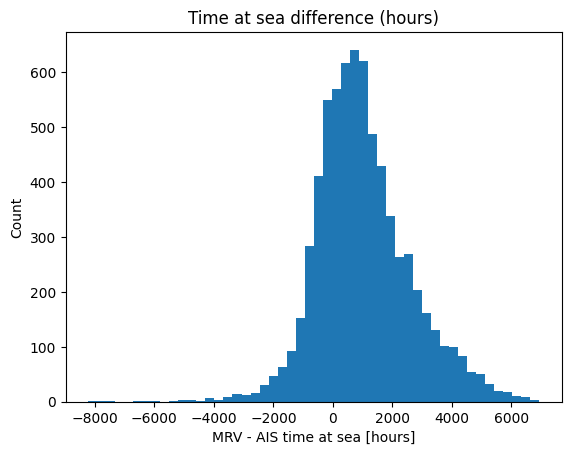

In [125]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df_time["time_diff_hours"], bins=50)
plt.xlabel("MRV - AIS time at sea [hours]")
plt.ylabel("Count")
plt.title("Time at sea difference (hours)")
plt.show()

Schlussfolgerung: AIS-aggregierte Zeit und MRV-„time spent at sea“ sind nur eingeschränkt vergleichbar und dürfen nicht als identische Metriken interpretiert werden.

* „Time at sea“ eignet sich nicht für quantitative Validierungsregeln.
* Sie liefert Kontext, aber keine harte Vergleichsbasis.

AIS ist auf Bewegungsdaten reduziert. MRV beinhaltet auch Liegezeiten

### Distanzvalidierung 
* Nicht möglich, da in MRV keine entsprechende Spalte vorhanden ist

## MRV Validierung - Final
* uns bleibt nur übrig, zu prüfen, ob sich zwei berichtete Kennzahlen im MRV-Datensatz konsistent stützen:
    * CO₂ emissions per distance  [kg CO₂ / nm]
    * Fuel consumption per distance [kg fuel / nm]

* Physikalisch gilt:
    * [CO₂ / nm] ≈ [Fuel / nm] * EF
        * EF: Emissionsfaktor (Fuel Type nicht vorhanden)

* Wir erwarten eine stabile lineare Beziehung

In [127]:
CO2_COL   = "CO₂ emissions per distance [kg CO₂ / n mile]"
FUEL_COL  = "Fuel consumption per distance [kg / n mile]"

In [128]:
df_eff = df_join.copy()

df_eff[CO2_COL]  = pd.to_numeric(df_eff[CO2_COL], errors="coerce")
df_eff[FUEL_COL] = pd.to_numeric(df_eff[FUEL_COL], errors="coerce")

df_eff = df_eff.dropna(subset=[CO2_COL, FUEL_COL])

### Impliziten Emissionsfaktor berechnen

In [129]:
df_eff["ef_implied"] = df_eff[CO2_COL] / df_eff[FUEL_COL]

In [130]:
df_eff["ef_implied"].describe()

count    6490.000000
mean        3.116833
std         0.096222
min         1.590969
25%         3.122667
50%         3.131977
75%         3.144883
max         3.206423
Name: ef_implied, dtype: float64

In [131]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = df_eff[[FUEL_COL]].values
y = df_eff[CO2_COL].values

lin = LinearRegression()
lin.fit(X, y)

y_hat = lin.predict(X)

print("Slope (kg CO2 per kg fuel):", lin.coef_[0])
print("Intercept:", lin.intercept_)
print("R²:", r2_score(y, y_hat))

Slope (kg CO2 per kg fuel): 3.1429304000127236
Intercept: -5.452690501064353
R²: 0.999999954676813


In [132]:
df_eff["residual_eff"] = y - y_hat

df_eff["residual_eff"].describe()

count    6.490000e+03
mean     2.759314e-13
std      1.062612e+02
min     -8.241909e+03
25%      3.337072e+00
50%      4.426578e+00
75%      5.613809e+00
max      1.375946e+03
Name: residual_eff, dtype: float64

Interpretation: Die in MRV gemeldete CO₂-Intensität und Kraftstoffintensität weisen eine starke lineare Beziehung auf, was auf eine interne Konsistenz der effizienzbezogenen Kennzahlen hindeutet.

Bedeutet nicht, dass das Reporting korrekt ist, sondern dass sich diese 2 Größen nicht widersprechen